In [1]:
# Discard the output of this cell.
#%%capture

# Install the required libraries.
!pip install tensorflow opencv-contrib-python youtube-dl moviepy pydot
!pip install git+https://github.com/TahaAnwar/pafy.git#egg=pafy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 6.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/TahaAnwar/pafy.git to /tmp/pip-install-6_jb9u4f/pafy_8d33f2b97bbf41c5950692bb8ae070c5
  Running command git clone -q https://github.com/TahaAnwar/pafy.git /tmp/pip-install-6_jb9u4f/pafy_8d33f2b97bbf41c5950692bb8ae070c5
  Created wheel for pafy: filename=pafy-0.5.5-py2.py3-none-any.whl size=35706 sha256=c54a862d5d3b1509f21b59a85ec86c6b3e6902aa16d0427d1fb9ab4af64db1bc
  Stored in directory: /tmp/pip-ephem-wheel-cache-vfhpg3e6/wheels/64/82/dd/3d7823b3bbbe1aca9b30f8cf0d6bb6c1b72ccd95e3360f8190
Successfully built pafy


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import the required libraries.
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2965504/45929032 bytes (6.5%)6701056/45929032 bytes (14.6%)10461184/45929032 bytes (22.8%)14090240/45929032 bytes (30.7%)17768448/45929032 bytes (38.7%)21585920/45929032 bytes (47.0%)25190400/45929032 bytes (54.8%)28901376/45929032 bytes (62.9%)32653312/45929032 bytes (71.1%)36339712/45929032 bytes (79.1%)40075264/45929032 bytes (87.3%)43835392/45929032 bytes (95.4%)

In [4]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 30

# Specify the directory containing the UCF50 dataset. 
DATASET_DIR = "/content/drive/MyDrive/SAVEEvideowithlabel/"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["neutral", "happy", "sad","angry","fearful"]

In [5]:
import joblib
path='/content/drive/My Drive/fusion/savee/audio/data_set/expert4/'
train_path_name=joblib.load(path+'train/video_train_path')
valid_path_name=joblib.load(path+'valid/video_valid_path')
test_path_name=joblib.load(path+'test/video_test_path')

labels_train=joblib.load(path+'train/labels_train')
labels_valid=joblib.load(path+'valid/labels_valid')
labels_test=joblib.load(path+'test/labels_test')


In [6]:
len(train_path_name),len(valid_path_name),len(test_path_name),len(labels_train),len(labels_valid),len(labels_test)

(288, 36, 36, 288, 36, 36)

In [7]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video. 
        success, frame = video_reader.read() 

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()

    # Return the frames list.
    return frames_list

In [8]:
def create_dataset(video_path):
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    #labels = []
    #video_files_paths = []
    #count=0
    # Iterating through all the classes mentioned in the classes list
    #for class_index, class_name in enumerate(CLASSES_LIST):
    for i in video_path:   
        # Display the name of the class whose data is being extracted.
        #print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        #files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        #for file_name in files_list:
            
            # Get the complete video path.
            #video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            video_file_path=DATASET_DIR+i
            print(video_file_path)
            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)
            
            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                #labels.append(class_index)
            

    # Converting the list to numpy arrays
    features = np.asarray(features)
    
    #labels = np.array(labels)  
    
    # Return the frames, class index, and video file path.
    return features

In [9]:
features_train=create_dataset(train_path_name)
features_test=create_dataset(test_path_name)
features_valid=create_dataset(valid_path_name)

/content/drive/MyDrive/SAVEEvideowithlabel/fearful/f11jk.avi
/content/drive/MyDrive/SAVEEvideowithlabel/angry/a4jk.avi
/content/drive/MyDrive/SAVEEvideowithlabel/angry/a14jk.avi
/content/drive/MyDrive/SAVEEvideowithlabel/angry/a6dc.avi
/content/drive/MyDrive/SAVEEvideowithlabel/happy/h14jk.avi
/content/drive/MyDrive/SAVEEvideowithlabel/fearful/f4kl.avi
/content/drive/MyDrive/SAVEEvideowithlabel/angry/a12je.avi
/content/drive/MyDrive/SAVEEvideowithlabel/neutral/n15dc.avi
/content/drive/MyDrive/SAVEEvideowithlabel/angry/a9kl.avi
/content/drive/MyDrive/SAVEEvideowithlabel/angry/a1dc.avi
/content/drive/MyDrive/SAVEEvideowithlabel/neutral/n27kl.avi
/content/drive/MyDrive/SAVEEvideowithlabel/angry/a10je.avi
/content/drive/MyDrive/SAVEEvideowithlabel/fearful/f6jk.avi
/content/drive/MyDrive/SAVEEvideowithlabel/fearful/f15je.avi
/content/drive/MyDrive/SAVEEvideowithlabel/fearful/f1kl.avi
/content/drive/MyDrive/SAVEEvideowithlabel/angry/a3jk.avi
/content/drive/MyDrive/SAVEEvideowithlabel/fearful

In [10]:
labels_train = np.array(labels_train)
labels_test = np.array(labels_test)
labels_valid = np.array(labels_valid)

In [11]:
features_train.shape,features_test.shape,features_valid.shape

((288, 30, 64, 64, 3), (36, 30, 64, 64, 3), (36, 30, 64, 64, 3))

In [12]:
labels_train.shape,labels_test.shape,labels_valid.shape

((288,), (36,), (36,))

In [13]:
labels_train = to_categorical(labels_train)
labels_test = to_categorical(labels_test)
labels_valid = to_categorical(labels_valid)

In [14]:
labels_train.shape,labels_test.shape,labels_valid.shape

((288, 5), (36, 5), (36, 5))

In [15]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()
   
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(16, (5, 5), padding='same'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Activation('relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.1)))
    
    model.add(TimeDistributed(Conv2D(32, (5, 5), padding='same')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Activation('relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(TimeDistributed(Conv2D(64, (5, 5), padding='same')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Activation('relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.3)))
    
    model.add(TimeDistributed(Conv2D(64, (5, 5), padding='same')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Activation('relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(64))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model


In [16]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 64, 64, 16)   1216      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 64, 64, 16)   64        
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 64, 64, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 16, 16, 16)   0

In [17]:

# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 25, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 100, batch_size = 4 ,
                                             shuffle = True, validation_data =(features_valid,labels_valid), callbacks = [early_stopping_callback])

Epoch 1/100
72/72 [==============================] - 16s 24ms/step - loss: 1.6220 - accuracy: 0.3160 - val_loss: 1.5460 - val_accuracy: 0.3611
Epoch 2/100
72/72 [==============================] - 1s 13ms/step - loss: 1.5653 - accuracy: 0.3681 - val_loss: 1.5665 - val_accuracy: 0.3611
Epoch 3/100
72/72 [==============================] - 1s 13ms/step - loss: 1.4894 - accuracy: 0.3854 - val_loss: 1.6057 - val_accuracy: 0.3611
Epoch 4/100
72/72 [==============================] - 1s 13ms/step - loss: 1.4795 - accuracy: 0.3715 - val_loss: 1.5643 - val_accuracy: 0.4167
Epoch 5/100
72/72 [==============================] - 1s 13ms/step - loss: 1.4488 - accuracy: 0.3958 - val_loss: 1.6977 - val_accuracy: 0.3611
Epoch 6/100
72/72 [==============================] - 1s 13ms/step - loss: 1.3889 - accuracy: 0.3993 - val_loss: 1.6468 - val_accuracy: 0.4167
Epoch 7/100
72/72 [==============================] - 1s 13ms/step - loss: 1.3400 - accuracy: 0.4236 - val_loss: 1.6204 - val_accuracy: 0.3889
Epoch

In [18]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

2/2 [==============================] - 1s 11ms/step - loss: 0.0792 - accuracy: 0.9722


In [19]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_train, labels_train)

9/9 [==============================] - 0s 29ms/step - loss: 0.0080 - accuracy: 1.0000


In [20]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
#date_time_format = '%Y_%m_%d__%H_%M_%S'
#current_date_time_dt = dt.datetime.now()
#current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'/content/drive/My Drive/fusion/savee/video/model/expert4/best_LRCN_model___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model.
LRCN_model.save(model_file_name)

In [21]:
from keras.models import save_model

# you can write whatever you desire instead of 'my_model'
# model = Your trained model
LRCN_model.save('/content/drive/My Drive/fusion/savee/video/model/expert4/best_LRCN_model')


INFO:tensorflow:Assets written to: /content/drive/My Drive/fusion/savee/video/model/expert4/best_LRCN_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/fusion/savee/video/model/expert4/best_LRCN_model/assets


In [22]:
# serialize model to JSON
model_json = LRCN_model.to_json()
with open("/content/drive/My Drive/fusion/savee/video/model/expert4/best_LRCN_model.json", "w") as json_file:
    json_file.write(model_json)

In [23]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

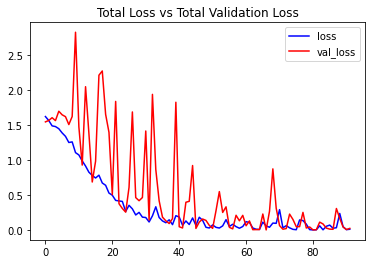

In [24]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

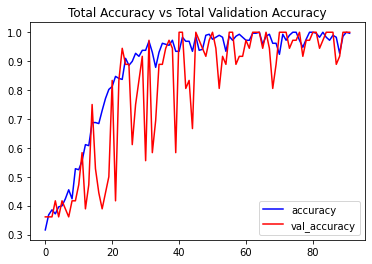

In [25]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [26]:
predictions =  LRCN_model.predict(features_test)
predictions

array([[1.6336153e-05, 9.7083652e-01, 4.4340445e-04, 3.7937441e-03,
        2.4910055e-02],
       [7.9532692e-06, 9.9307430e-01, 4.2517124e-05, 3.9245581e-04,
        6.4828284e-03],
       [5.1018280e-05, 4.1429242e-03, 2.9796115e-03, 6.6205408e-05,
        9.9276030e-01],
       [1.1346088e-04, 1.9453779e-01, 3.1329694e-03, 1.9535024e-03,
        8.0026221e-01],
       [6.9274046e-03, 1.7419111e-03, 5.7029676e-01, 4.2253104e-04,
        4.2061135e-01],
       [1.2949479e-04, 1.1872281e-03, 9.1813382e-04, 9.9728858e-01,
        4.7651716e-04],
       [1.6195874e-04, 4.7231163e-03, 8.0801593e-03, 1.5487983e-04,
        9.8687983e-01],
       [3.1731476e-03, 1.9797655e-04, 9.5913970e-01, 3.5274276e-04,
        3.7136391e-02],
       [9.9868315e-01, 4.9454593e-06, 1.0620555e-03, 2.2749840e-04,
        2.2280741e-05],
       [5.4152231e-05, 9.8613900e-01, 1.5013551e-04, 3.3995390e-03,
        1.0257200e-02],
       [9.9603301e-01, 2.8058664e-06, 3.7927113e-03, 1.1929073e-04,
        5.20

In [27]:
preds=predictions.argmax(axis=1)
preds

array([1, 1, 4, 4, 2, 3, 4, 2, 0, 1, 0, 2, 1, 0, 4, 1, 4, 1, 0, 2, 0, 1,
       0, 1, 4, 1, 0, 0, 4, 0, 2, 3, 2, 0, 4, 1])

In [28]:
new_preds = preds.astype(int).flatten()
new_preds

array([1, 1, 4, 4, 2, 3, 4, 2, 0, 1, 0, 2, 1, 0, 4, 1, 4, 1, 0, 2, 0, 1,
       0, 1, 4, 1, 0, 0, 4, 0, 2, 3, 2, 0, 4, 1])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.91      0.95        11
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         2
           4       0.88      1.00      0.93         7

    accuracy                           0.97        36
   macro avg       0.97      0.98      0.98        36
weighted avg       0.98      0.97      0.97        36

----accuracy score 97.22222222222221 ----


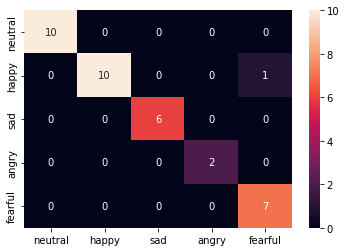

In [29]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
import seaborn as sn
import pandas as pd
import numpy as np
new_labels=np.argmax(labels_test, axis=1)
print(classification_report(new_labels,new_preds))

acc = float(accuracy_score(new_labels,new_preds))*100
print("----accuracy score %s ----" % acc)

cm = confusion_matrix(new_labels,new_preds)
#df_cm = pd.DataFrame(cm)
class_names = ['neutral', 'happy','sad','angry', 'fearful' ]
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names,)
sn.heatmap(df_cm, annot=True, fmt='')
plt.show()

In [30]:
predictions_train=LRCN_model.predict(features_train)
predictions_valid=LRCN_model.predict(features_valid)

In [31]:
df_video_train=pd.DataFrame(predictions_train,columns=["OV_"+str(i) for i in range(5)]) 
df_video_test=pd.DataFrame(predictions,columns=["OV_"+str(i) for i in range(5)]) 
df_video_valid=pd.DataFrame(predictions_valid,columns=["OV_"+str(i) for i in range(5)])

In [32]:
save_dir = '/content/drive/My Drive/fusion/savee/video/data_set/expert4'

savedvX = joblib.dump(df_video_train, os.path.join(save_dir, 'train/pred_train'))
savedvX = joblib.dump(df_video_test, os.path.join(save_dir, 'test/pred_test'))
savedvX = joblib.dump(df_video_valid, os.path.join(save_dir, 'valid/pred_valid'))